In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
from datetime import datetime, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm
from scipy import stats
from scipy.special import inv_boxcox, logit
from scipy.special import expit as sigmoid
from scipy.special import softmax

from scripts.compute_transition_matrices import plot_transition_matrix
# from model.ball_base_model import *
from model import baseline
from model.helpers import square_exponential_kernel, normalize_last_dim
from plot import plot
from data.data_path import data_path

In [3]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [4]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# Load data
step_events = load_data(user)
print("n_days raw", len(step_events))
step_events = [i for i in step_events if len(i)]
n_days = len(step_events)
print("n_days after filtering empty days", len(step_events))

n_days raw 18
n_days after filtering empty days 17


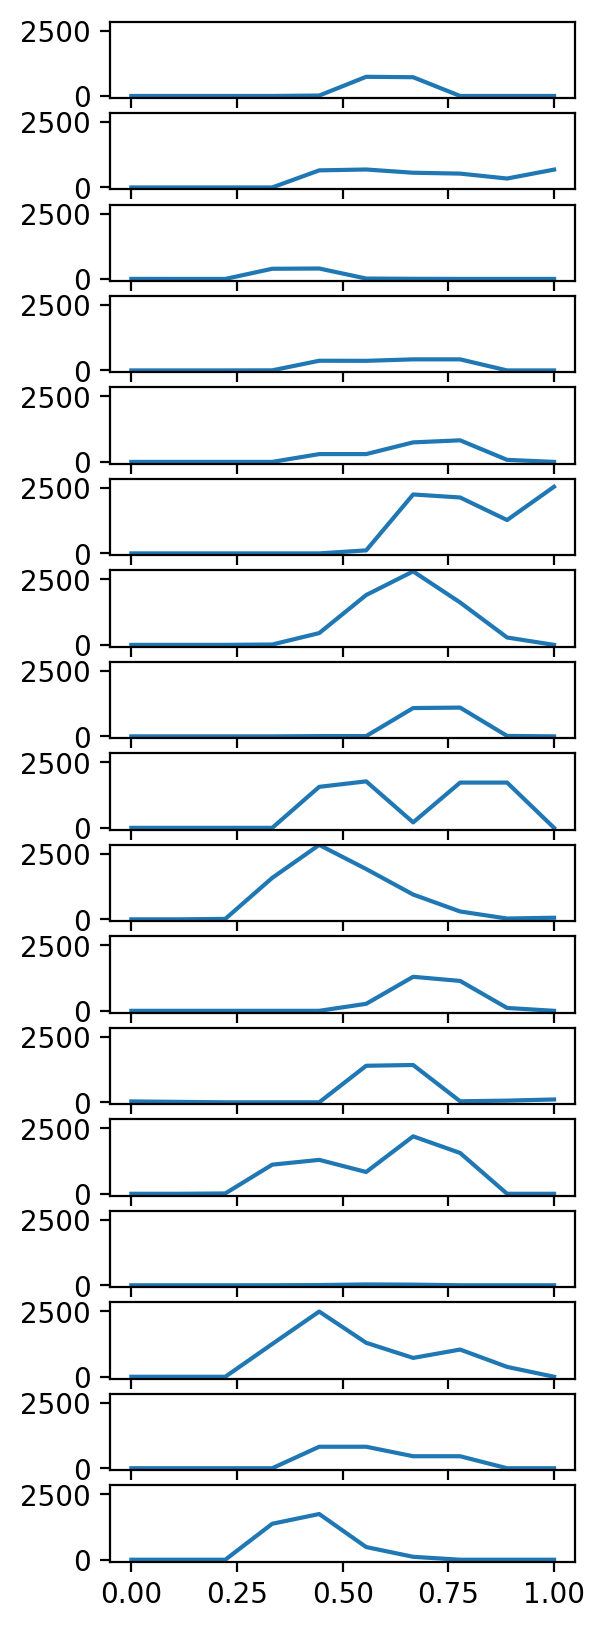

In [5]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

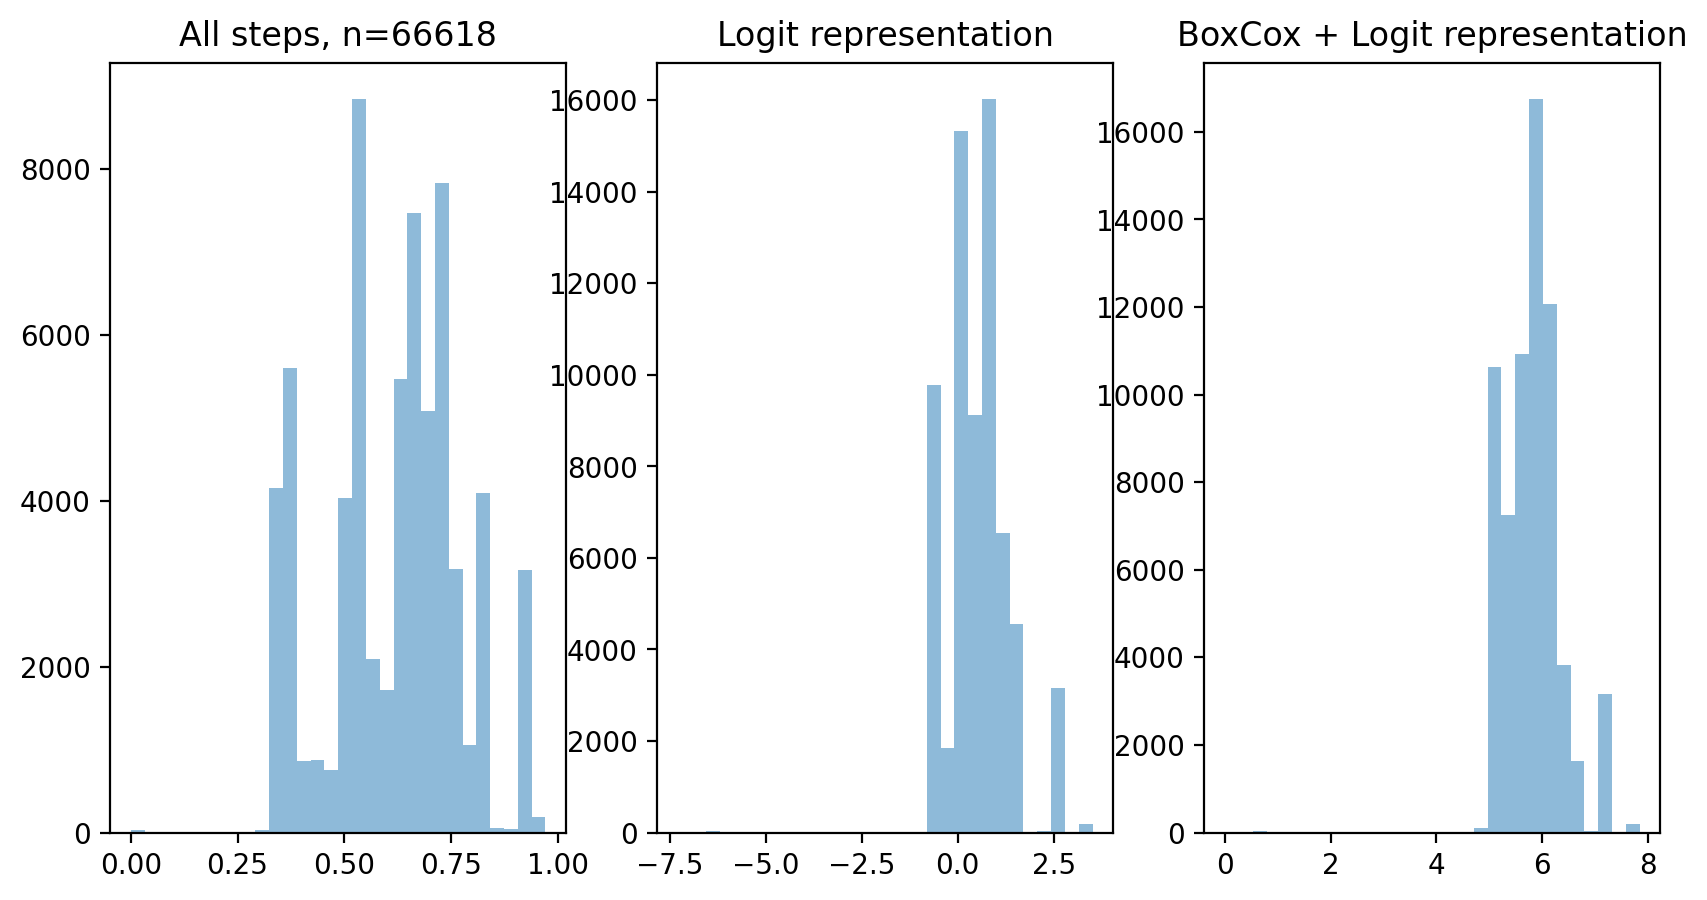

In [6]:
all_steps = np.concatenate(step_events)
fig, axes = plt.subplots(ncols=3, figsize=(10, 5))

ax = axes[0]
ax.set_title(f"All steps, n={len(all_steps)}")
ax.hist(all_steps, bins=30, color="C0", alpha=0.5)

ax = axes[1]
ax.set_title("Logit representation")
ax.hist(logit(all_steps), bins=30, color="C0", alpha=0.5)
    
step_scaler = MinMaxScaler(feature_range=(1, 10))
scaled = step_scaler.fit_transform(logit(all_steps).reshape(-1, 1)).flatten()
transformed_all_steps, lambda_param = stats.boxcox(scaled)
ax = axes[2]
ax.set_title("BoxCox + Logit representation")
ax.hist(transformed_all_steps, bins=30, color="C0", alpha=0.5);

In [7]:
# Define the range of number of components to try
n_components_range = range(1, 51)

# Array to hold the BIC for each number of components
cmp_score = np.zeros((n_days, len(list(n_components_range))))

for day in tqdm(range(n_days)):
    # print(f"Day {day}", len(step_events[day]), "steps")
    X = logit(np.asarray(step_events[day]).reshape(-1, 1))
    
    # Fit a Gaussian Mixture Model for each number of components
    for i, n_components in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        cmp_score[day, i] = gmm.bic(X)

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
len(list(n_components_range))

50

n days 17


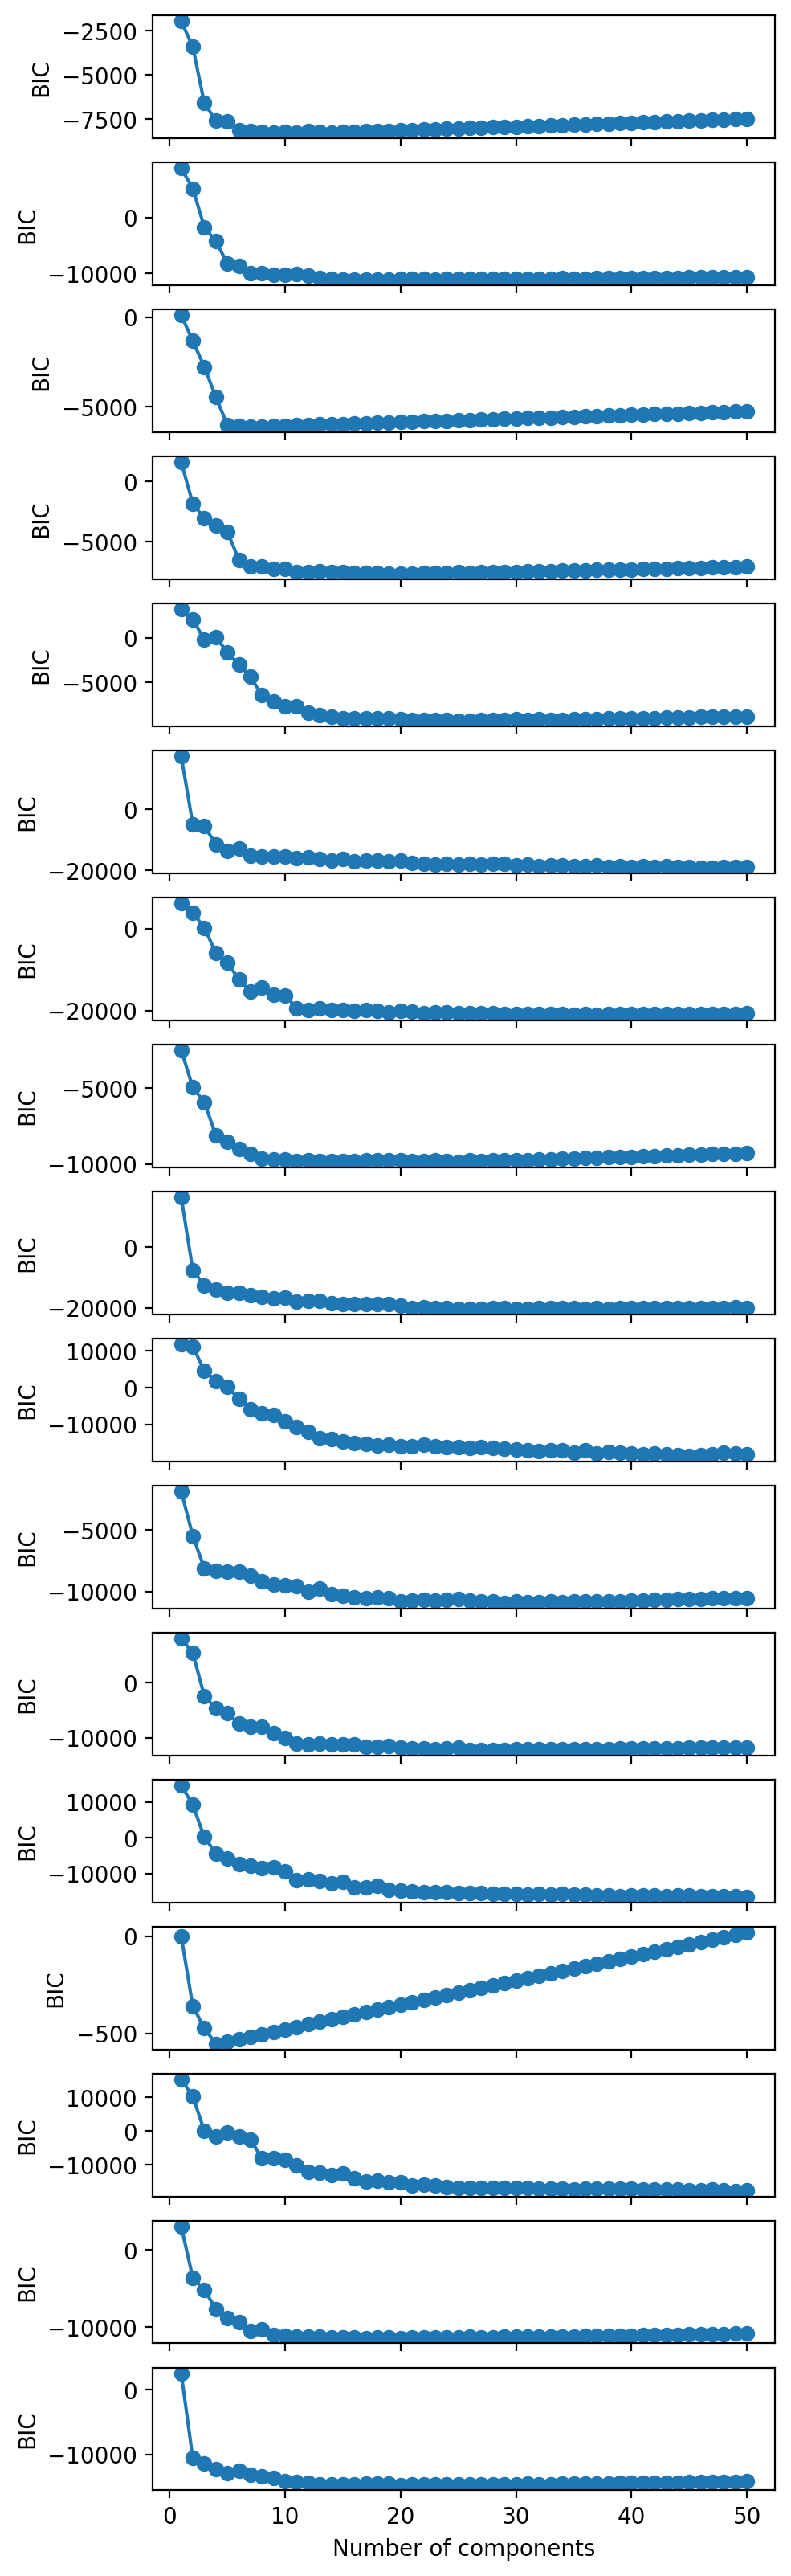

In [9]:
fig, axes = plt.subplots(nrows=n_days, figsize=(5, 20), sharex=True)
print("n days", n_days)
for day in range(n_days):
    ax = axes[day]
    ax.plot(n_components_range, cmp_score[day], marker='o')
    if day == n_days-1:(
        ax.set_xlabel('Number of components'))
    ax.set_ylabel('BIC')

In [10]:
param = np.zeros((n_days, 3)) # mu, sigma, n

# Define the range of number of components to try
n_components_range = range(1, 11)
cmp_score = np.zeros((n_days, len(list(n_components_range))))

max_n = max([len(step_events[day]) for day in range(n_days)])

for day in range(n_days):
    X = np.asarray(step_events[day])
    param[day] = logit(X.mean()), np.log(X.std()), np.exp(X.size/max_n)

In [11]:
gmm = GaussianMixture(n_components=1)
gmm.fit(param)
print("Means:", gmm.means_)
print("Covariances:", gmm.covariances_)

Means: [[ 0.45103159 -2.51574731  1.76193222]]
Covariances: [[[0.16647998 0.03108194 0.03242622]
  [0.03108194 0.37595569 0.23042733]
  [0.03242622 0.23042733 0.35684444]]]


In [12]:
n_samples = 5
samples, _ = gmm.sample(n_samples)

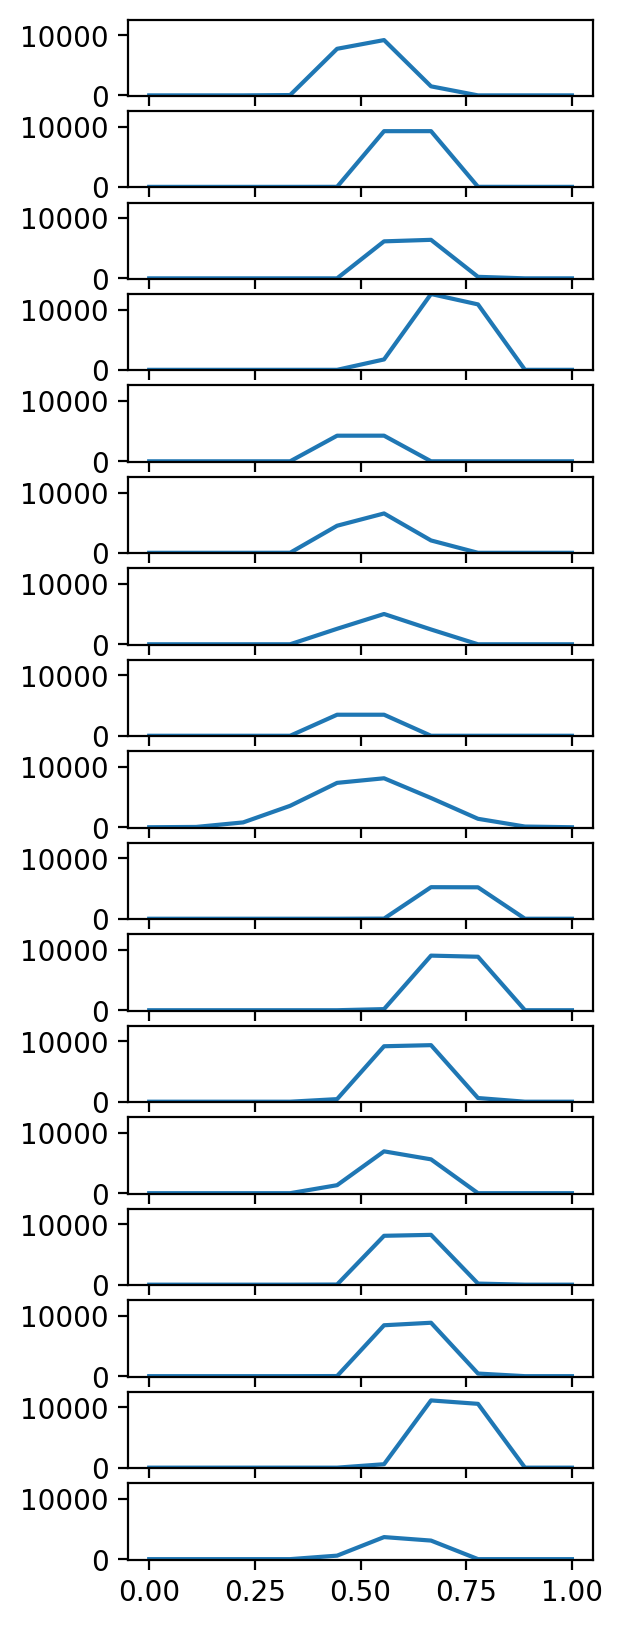

In [13]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    samples, _ = gmm.sample(1)
    smp = samples[0]
    mu = smp[0]
    sigma = np.exp(smp[1])
    n = smp[2]*max_n
    
    draws = np.random.normal(mu, sigma, size=int(n))
    
    step_events_day = sigmoid(draws)
    
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [14]:
# Define the range of number of components to try
n_components_range = range(1, 5)
n_model_types = len(list(n_components_range))

goodness_of_fit = np.zeros((n_days, n_model_types))
params = []  
for n_comp in n_components_range:
    if n_comp == 1:
        # for each model: per day, logit(mean), log1p(var), n
        params.append(np.zeros((n_days, 3)))
    else:
        # for each model: per day, logit(means), log1p(var), logit(coeff)
        params.append(np.zeros((n_days, n_comp*3+1)))

max_n = max([len(step_events[day]) for day in range(n_days)])

cmp_score = np.zeros((n_days, n_model_types))

# 1. Fit 1st level GMMs with different number of components for each day
for day in range(n_days):
    X = np.asarray(step_events[day]).reshape(-1, 1)
    for model, n_components in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        cmp_score[day, model] = gmm.bic(X)
        
        transformed_means = logit(gmm.means_).flatten()
        transformed_vars = np.log1p(gmm.covariances_).flatten()
        transformed_weights = logit(gmm.weights_).flatten()
        transformed_n = np.atleast_1d(np.log(X.size / max_n))
        
        if n_components == 1:
            features = [transformed_means, transformed_vars, transformed_n]

        else:
            features = [transformed_means, transformed_vars, transformed_weights, transformed_n]
        params[model][day] = np.concatenate(features)

# 2. Fit a 2nd level GMM per type of model
second_level_gmm = [GaussianMixture(n_components=1).fit(params[model]) for model in range(n_model_types)]

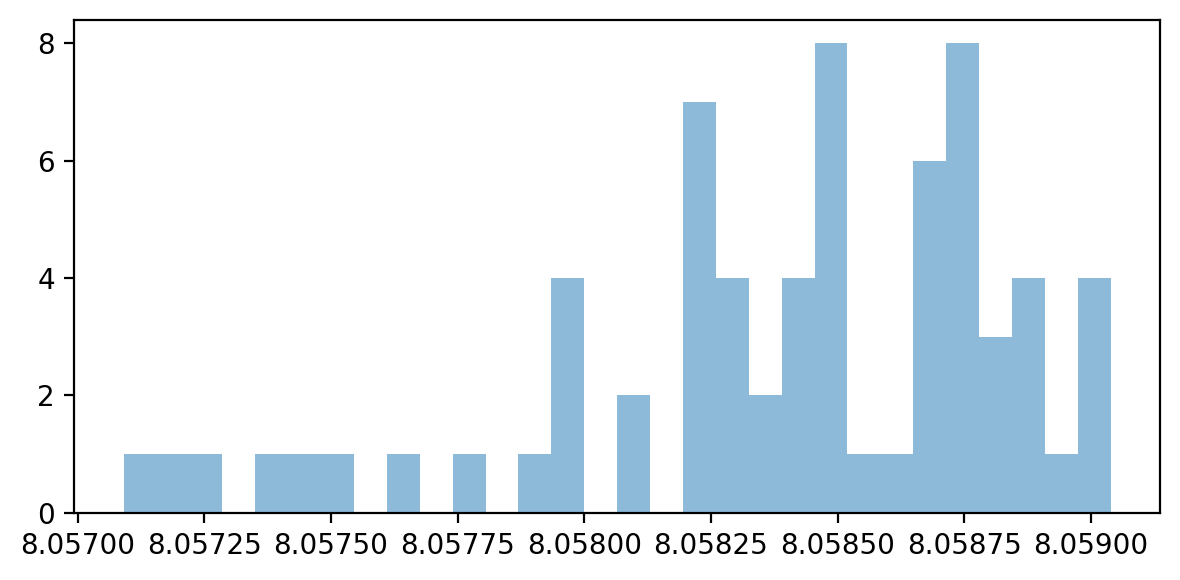

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(np.log(np.sqrt(1e7+cmp_score.flatten())), bins=30, color="C0", alpha=0.5)
plt.tight_layout()

In [16]:
org_shape = cmp_score.shape
score_scaler = MinMaxScaler(feature_range=(1, 10))
scaled_scores = score_scaler.fit_transform(cmp_score.flatten().reshape(-1, 1)).flatten()
transformed_scores, lambda_param = stats.boxcox(scaled_scores)
transformed_scores = transformed_scores.reshape(org_shape)

In [17]:
untransformed_scores_ = inv_boxcox(transformed_scores.flatten().reshape(-1, 1), lambda_param)
untransformed_scores = score_scaler.inverse_transform(untransformed_scores_).reshape((-1, n_model_types))

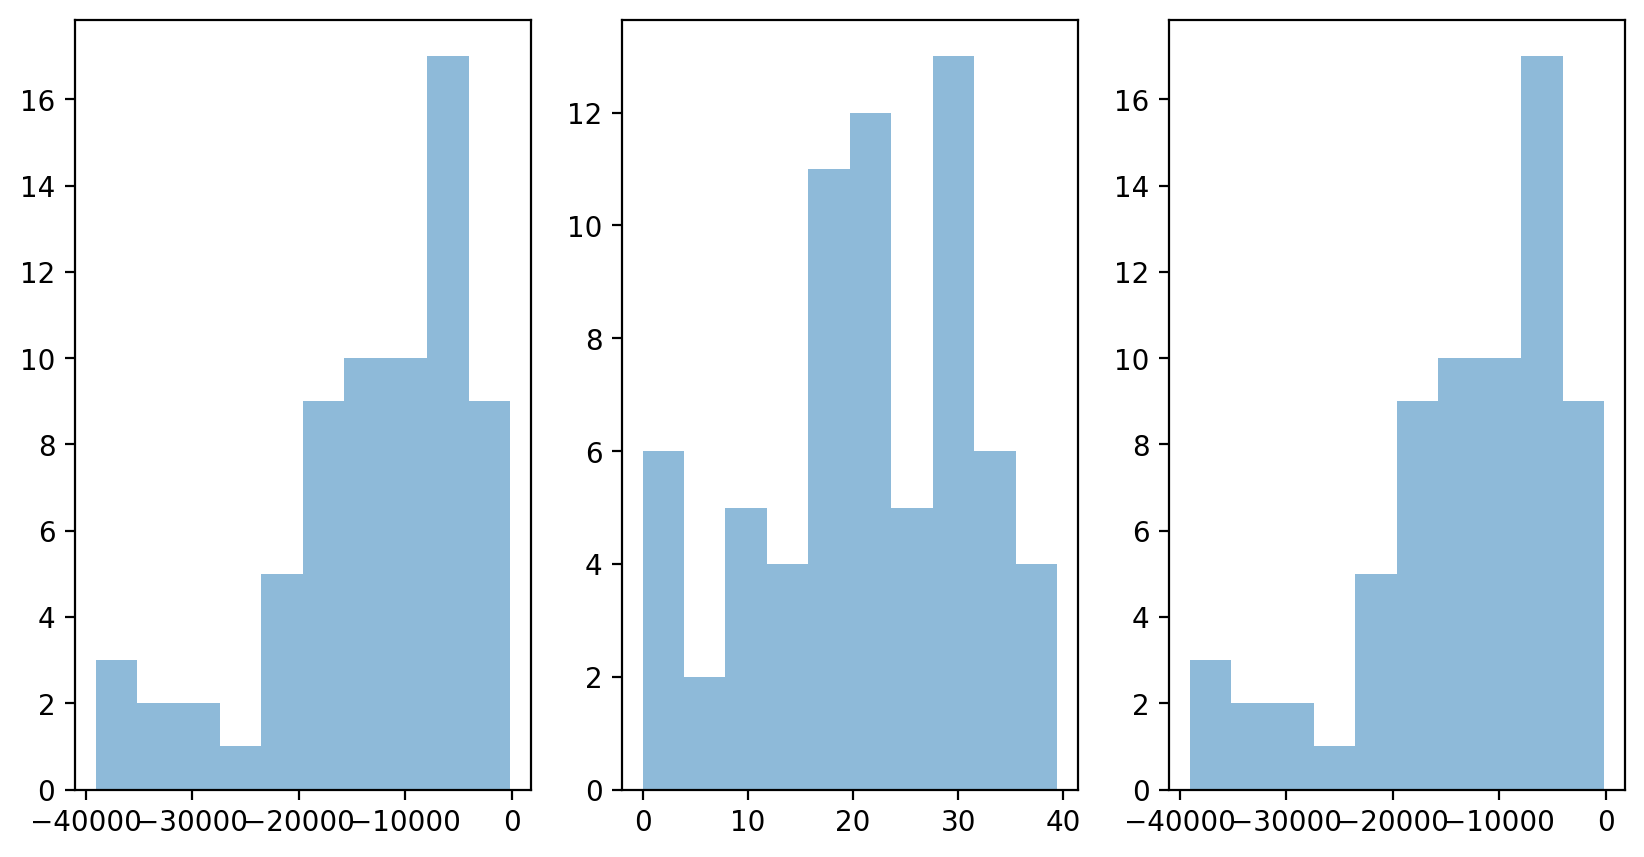

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].hist(cmp_score.flatten(), color="C0", alpha=0.5)
ax[1].hist(transformed_scores.flatten(), color="C0", alpha=0.5)
ax[2].hist(untransformed_scores.flatten(), color="C0", alpha=0.5);

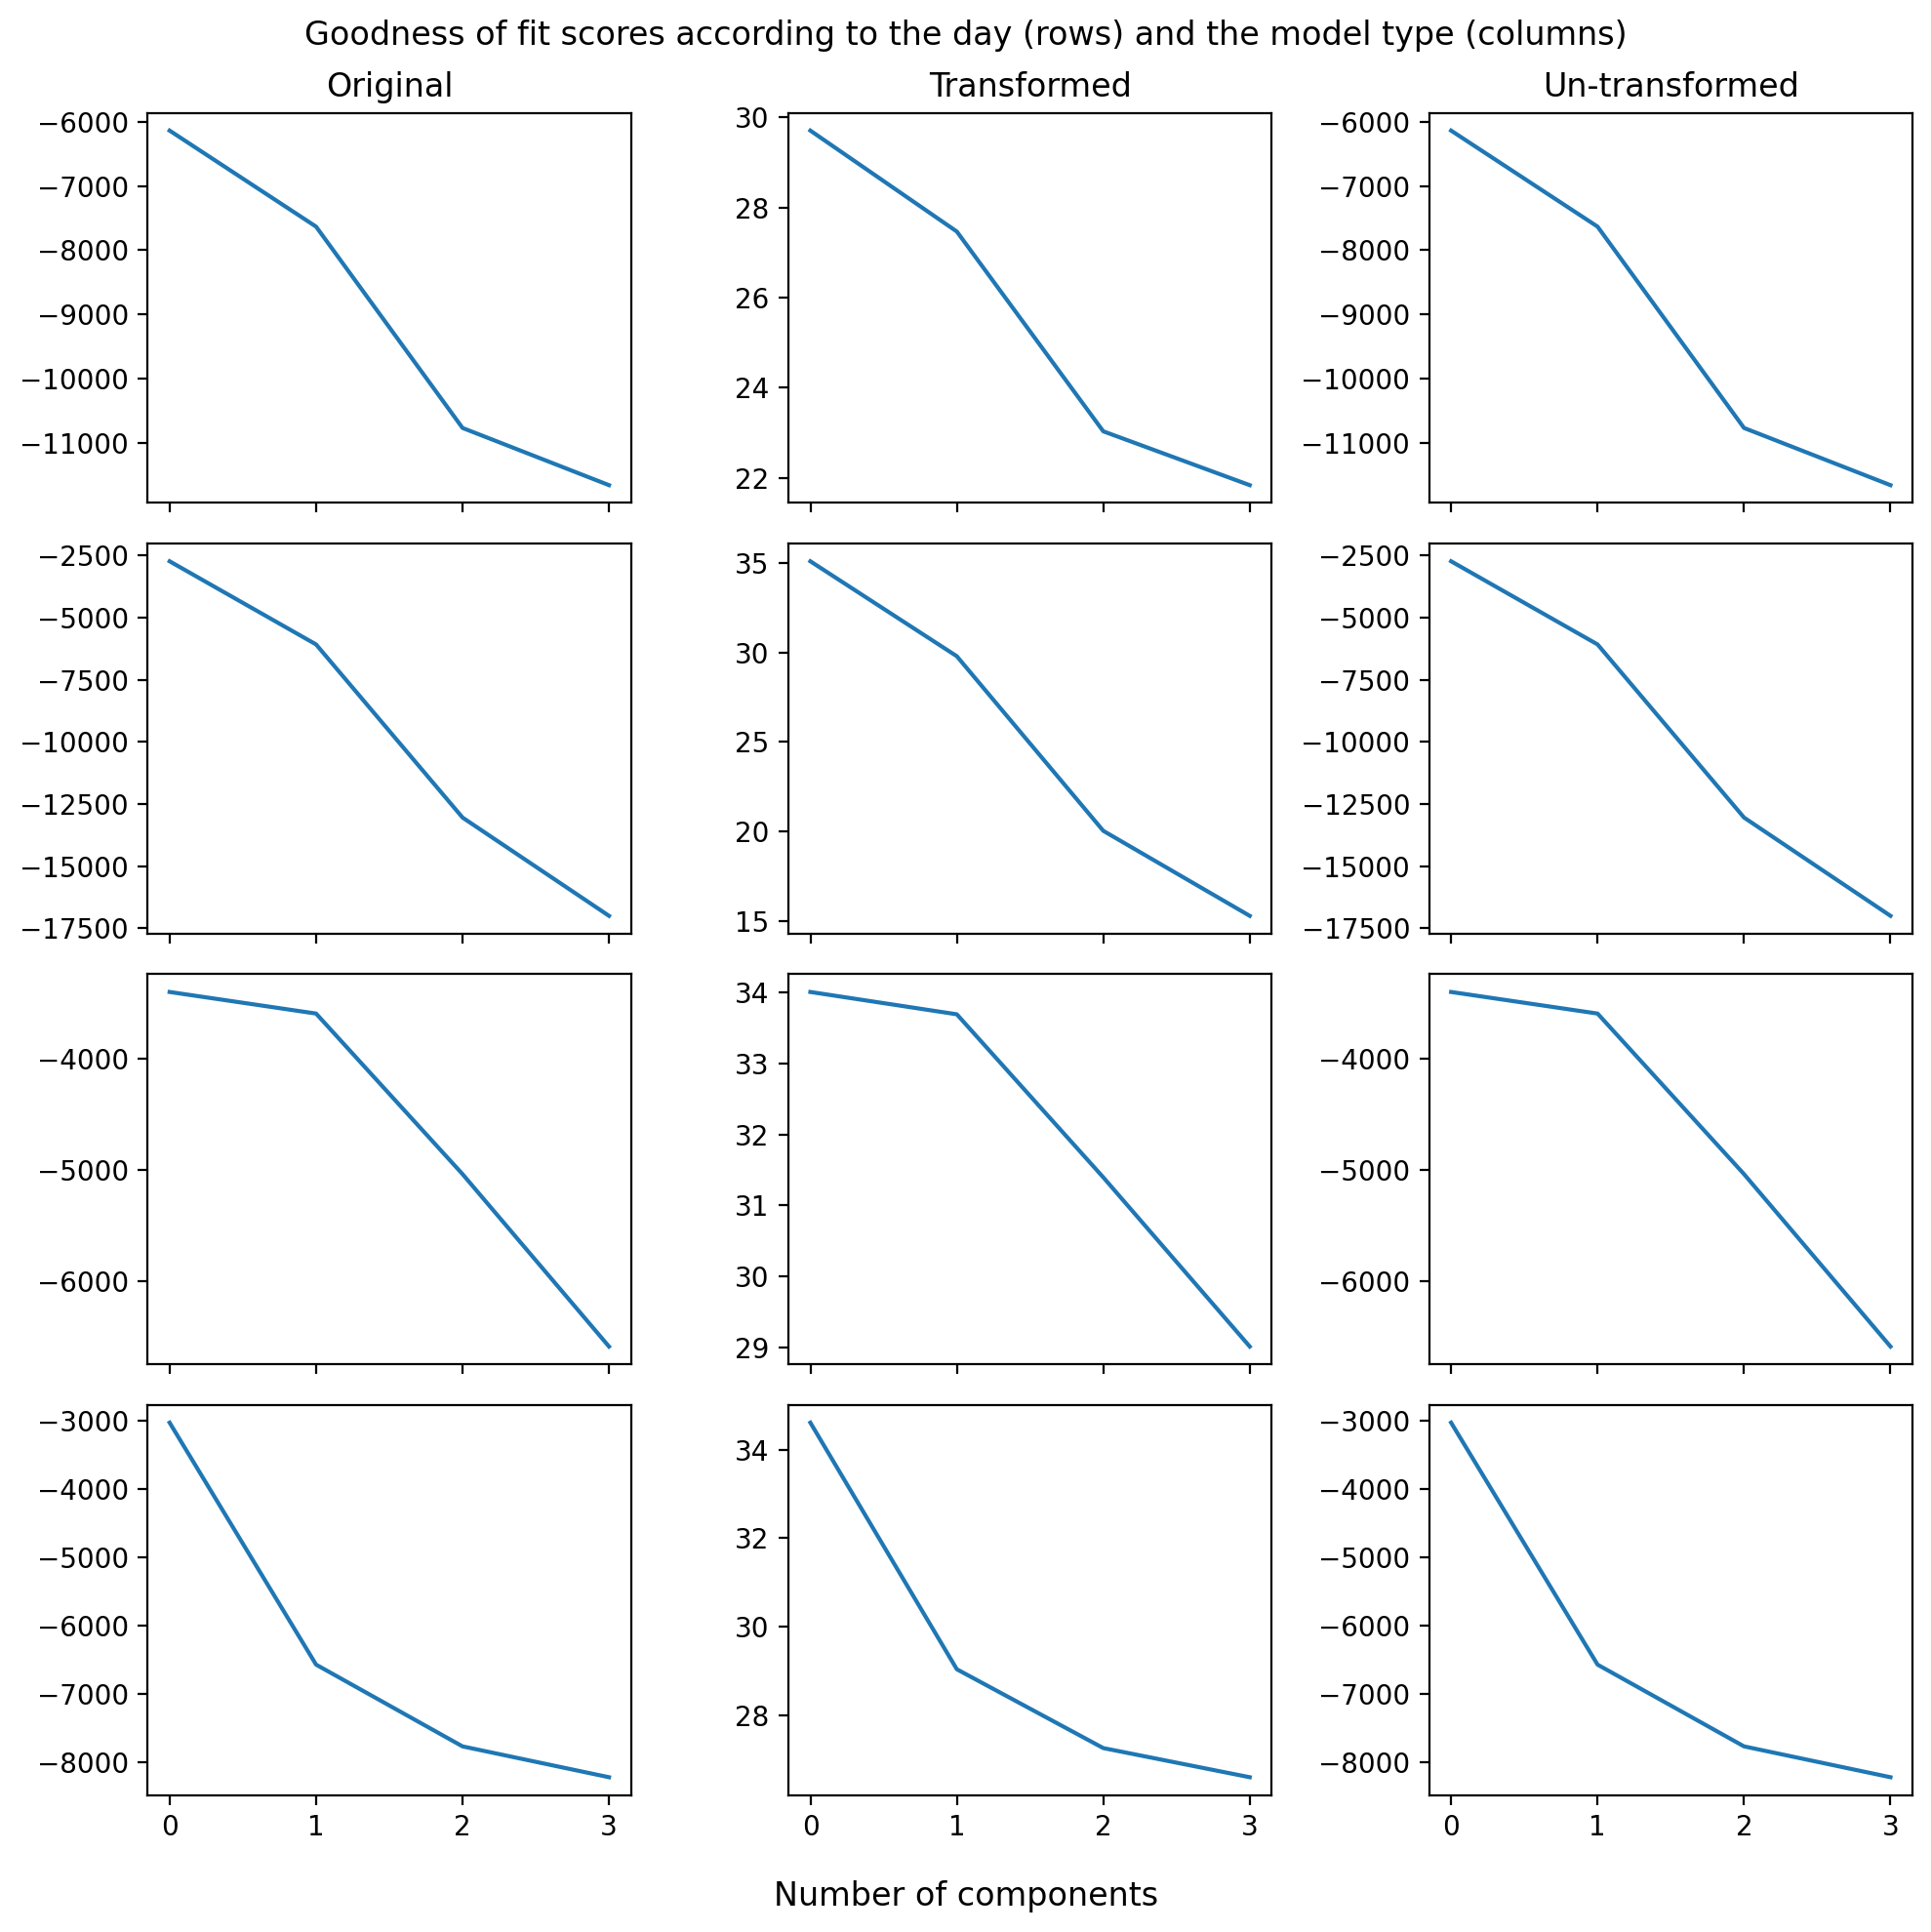

In [19]:
fig, axes = plt.subplots(nrows=n_model_types, ncols=3, figsize=(10, 10), sharex=True, sharey=False)
fig.set_tight_layout(True)
fig.suptitle("Goodness of fit scores according to the day (rows) and the model type (columns)")
fig.supxlabel("Number of components")
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Transformed")
axes[0, 2].set_title("Un-transformed")
for day in range(cmp_score.shape[1]):
    ax = axes[day, 0]
    ax.plot(cmp_score[day])
    
    ax = axes[day, 1]
    ax.plot(transformed_scores[day])
    
    ax = axes[day, 2]
    ax.plot(untransformed_scores[day])

In [20]:
# 3. Fit a 3rd level GMM with the bic scores
all_third_level_gmm = []
all_third_level_gmm_scores = []
for n_components in n_components_range:
    third_level_gmm = GaussianMixture(n_components=n_components, random_state=34)
    third_level_gmm.fit(transformed_scores)
    all_third_level_gmm_scores = third_level_gmm.bic(transformed_scores)


417.58502254412974
437.4310056743253
362.31294912984185


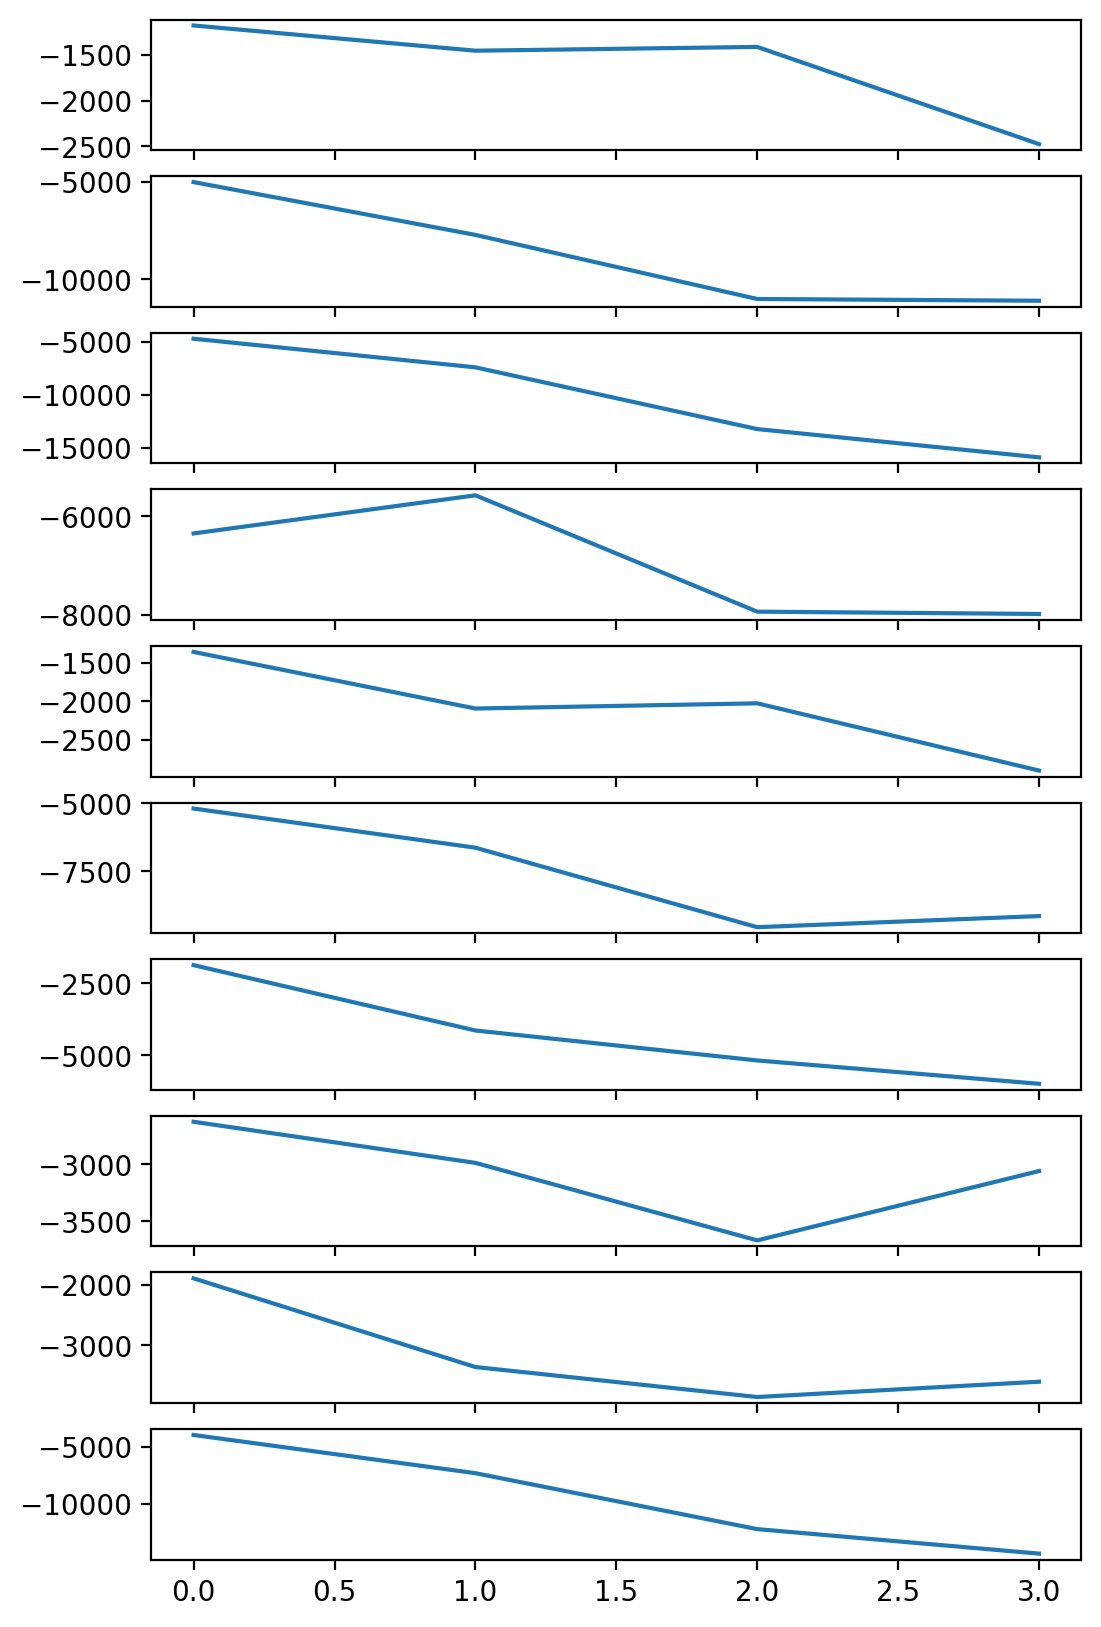

In [21]:
print()

third_level_gmm = GaussianMixture(n_components=1, random_state=34)
third_level_gmm.fit(transformed_scores)
print(third_level_gmm.bic(transformed_scores))

# 3. Fit a 3rd level GMM with the bic scores
third_level_gmm = GaussianMixture(n_components=2, random_state=34)
third_level_gmm.fit(transformed_scores)
print(third_level_gmm.bic(transformed_scores))

# 3. Fit a 3rd level GMM with the bic scores
third_level_gmm = GaussianMixture(n_components=3, random_state=34)
third_level_gmm.fit(transformed_scores)
print(third_level_gmm.bic(transformed_scores))

# How many days to sample
n_sample_3rd = 1000

samples_3rd, _ = third_level_gmm.sample(n_samples=n_sample_3rd)
# print(np.isnan(samples).sum())

# fig, axes = plt.subplots(figsize=(6, 10), sharex=True, nrows=n_sample)
# for day in range(n_sample):
#     ax = axes[day]
#     ax.plot(samples[day])

samples_3rd = inv_boxcox(samples_3rd.flatten().reshape(-1, 1), lambda_param)
samples_3rd = score_scaler.inverse_transform(samples_3rd).reshape((-1, n_model_types))

n_sample_plot = min(n_sample_3rd, 10)
fig, axes = plt.subplots(figsize=(6, 10), sharex=True, nrows=n_sample_plot)
for day in range(n_sample_plot):
    ax = axes[day]
    ax.plot(samples_3rd[day])

In [22]:
np.random.seed(1234)

deriv_cum_steps = np.zeros((n_sample, n_timestep))

for day in range(n_sample):
    
    # Choose with type of model to use ---------------------------
    
    # Draw a model type according to the goodness of fit 
    smp = samples_3d[day]
    print(smp)
    norm_score = (smp-smp.mean())/smp.std()
    p_according_to_gof = softmax(norm_score)
    
    model_idx = np.random.choice(n_model_types, p=p_according_to_gof)
    print(f"Day {day} is generated with model {model_idx+1}")

    # Draw the parameters of the 3rd level model using the 2nd level---------------------------
    second_level_gmm[model_idx].random_state = day
    samples_2nd, _ = second_level_gmm[model_idx].sample(n_samples=1)
    smp_2nd = samples_2nd[0]
    
    n_comp = list(n_components_range)[model_idx]
    
    transformed_means = smp_2nd[:n_components_range[model_idx]]
    transformed_vars = smp_2nd[n_components_range[model_idx]:2*n_components_range[model_idx]]
    if n_comp == 1:
        transformed_n = smp_2nd[2*n_components_range[model_idx]]
        transformed_weights = np.empty(0)
    else:
        transformed_weights = smp_2nd[2*n_components_range[model_idx]:3*n_components_range[model_idx]]
        transformed_n = smp_2nd[3*n_components_range[model_idx]]
        
    means = sigmoid(transformed_means)
    variances = np.expm1(transformed_vars)
    if n_comp == 1:
        weights = np.array([1])
    else:
        weights = softmax(transformed_weights)  # We want it to sum to 1
    n = int(np.exp(transformed_n) * max_n)
    
    gmm = GaussianMixture(n_components=n_comp)
    gmm.means_ = means.reshape(-1, 1)
    gmm.covariances_ = variances.reshape(-1, 1, 1)
    gmm.weights_ = weights
    
    print("n", n)
    samples_1st, _ = gmm.sample(n_samples=n) 
    
    step_events_day = np.sort(samples_1st.flatten())
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
    deriv_cum_steps[day] = deriv_cum_steps_day 

NameError: name 'n_sample' is not defined

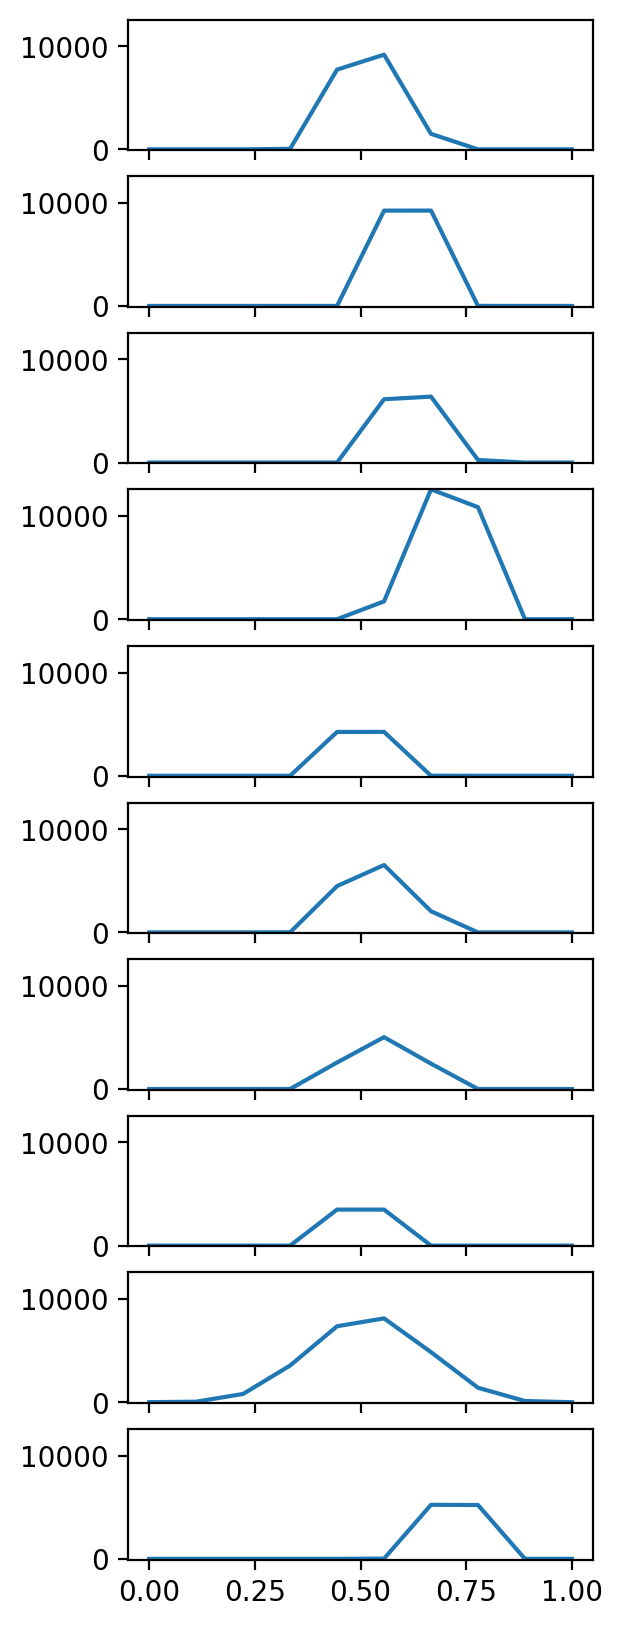

In [23]:
fig, axes = plt.subplots(min(deriv_cum_steps.shape[0], 10), figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)